In [1]:
%matplotlib inline  

In [ ]:
import os
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
import matplotlib.ticker as ticker

import warnings
warnings.simplefilter("ignore", UserWarning)

In [3]:
os.chdir("..")

In [ ]:
from Prior_optimization.gpr import GPR
from Prior_optimization import mean_functions, kernels
from Networks.factorized_gaussian_reparam_mlp import FactorizedGaussianMLPReparameterization
from Networks.mlp import MLP
from Networks.mlp_masked import MLPMasked
from Samplers.likelihoods import LikCategorical
from Prior_optimization.priors import OptimGaussianPrior
from Utilities.rand_generators import ClassificationGenerator
from Utilities import util
from Networks.classification_net_masked import ClassificationNetMasked
from Prior_optimization.sinkhorn_optimisation import SinkhornMapper

In [5]:
util.set_seed(123)

# 1. Load `Banana` dataset

In [6]:
DATA_DIR = "./data/banana"
OUT_DIR = "./exp/banana"

In [7]:
# Load banana dataset
X = np.loadtxt(os.path.join(
    DATA_DIR, "banana_X_train"), delimiter=",").astype(np.float32)
y = np.loadtxt(os.path.join(
    DATA_DIR, "banana_Y_train"), delimiter=",").reshape([-1]).astype(np.int64)

In [8]:
# Setup directories
ckpt_dir = os.path.join(OUT_DIR, "ckpts")
figs_dir = os.path.join(OUT_DIR, "figs")
util.ensure_dir(ckpt_dir)
util.ensure_dir(figs_dir)

# 2. Configure hyper-parameters

Configure the neural network architecture. In this experiment, we use a 2-hidden layer MLP with tanh activation function. The number of hidden units at each layer is 100.

In [9]:
input_dim = 2
output_dim = 2
hidden_dims = [100] * 2
activation_fn = "tanh"

Configure the hyper-parameters of Sinkhorn optimization.  

In [10]:
# Must be adapted 


mapper_batch_size = 256        # The size of the measurement set. The measurement points are sampled from the training data.
mapper_n_samples = 128         # The size of mini batch used in Wasserstein optimization
mapper_n_lipschitz_iters = 200 # The number of Lipschitz function iterations per prior iteration
mapper_n_prior_iters = 200     # The number of prior iterations
mapper_lipschitz_lr = 0.02     # The learning rate for the opimization of the Lipschitz function (inner loop)
mapper_prior_lr = 0.05         # The learning rate for the optimization of the prior (outer loop)

To reduce the running time of this demonstration, we use 100 iterations of Wasserstein optimization instead of 200 as used in the paper. However, the results are mostly similar. In order to reproduce exactly the results in the paper, please change `mapper_n_prior_iters = 100` to `mapper_n_prior_iters = 200`.

Configure the hyper-parameters for the SGHMC sampler.  

In [11]:
sampler_batch_size = 32
sampling_configs = {
    "batch_size": sampler_batch_size, # Mini-batch size
    "num_samples": 40,                # Total number of samples for each chain 
    "n_discarded": 10,                # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 200,         # Number of burn-in steps
    "keep_every": 200,                # Thinning interval
    "lr": 1e-2,                       # Step size
    "num_chains": 4,                  # Number of chains
    "mdecay": 1e-2,                   # Momentum coefficient
    "print_every_n_samples": 5
}
lambd_sd = torch.tensor([5e-1, 1.])
D = 3
num_samples = 60
num_iters_sd = 5000
print_every = 100
num_burn_in_steps = 200
num_datapoints = X.shape[0]

Attention, to reduce the running time of this demonstration, we use just 1 chain of sampling instead of 4 chains as used in the paper. To reproduce exactly the results in the paper, please change `"num_chains": 1` to `"num_chains": 4`, and `"num_samples": 60` to `"num_samples": 40`.

Setup the values of lengthscales and variances of the taret GP prior.

In [12]:
variances = [1, 32]
lengthscales = [1, 4, 16]

# 3. Optimize priors

## Optimize Sparse Prior

In [ ]:
masks_list = []
for variance in variances:
    for lengthscale in lengthscales:
        print("----" * 20)
        print("Lengthscale: {}; Variance: {}".format(lengthscale, variance))

        # Initialize data loader for the mapper
        data_loader = data_utils.DataLoader(
                            data_utils.TensorDataset(torch.from_numpy(X),
                                                     torch.from_numpy(y)),
                            batch_size=mapper_batch_size, shuffle=True)
        
        # Setup the measurement set generator
        # We draw measurement points from the training data
        rand_generator = ClassificationGenerator(data_loader)

        # Specify the target GP prior
        X_, y_ = rand_generator.get(return_label=True)
        kernel = kernels.RBF(
            input_dim,
            lengthscales=torch.tensor([lengthscale], dtype=torch.double),
            variance=torch.tensor([variance], dtype=torch.double))
        gp = GPR(X_.reshape([mapper_batch_size, -1]).double(),
                            util.to_one_hot(y_, 2).double(),
                            kern=kernel, mean_function=mean_functions.Zero())

        # Initialize tunable MLP prior
        mlp_reparam = FactorizedGaussianMLPReparameterization(input_dim, output_dim,
            hidden_dims, activation_fn, D= D, scaled_variance=True)
        
        # Initialize the mapper
        saved_dir = os.path.join(OUT_DIR, "len_{}_var_{}".format(
            lengthscale, variance))
        if not os.path.isfile(saved_dir):
            os.makedirs(saved_dir, exist_ok=True)
        mapper = SinkhornMapper(out_dir=saved_dir)
        
        # Start optimization
        # y_tensor = torch.tensor(y)
        # y_train_shape = y_tensor.unsqueeze(1).shape
        # y_train = y_tensor.unsqueeze(2).expand(y_train_shape[0], num_samples, y_train_shape[1]) 
        y_tensor = torch.tensor(y)  # Assumes y is 1D: (batch_size,)
        y_train = y_tensor[:, None, None].expand(-1, num_samples, 1)
        print("Start optimizing prior")
        p_hist, loss_hist = mapper.optimize_sparse(net = mlp_reparam, gp = gp, data_generator = rand_generator, 
            lambd= lambd_sd, n_data = mapper_batch_size, num_iters = num_iters_sd, print_every=print_every, output_dim = 1, 
            D= D, X_train = X, y_train= y_train, n_samples = num_samples)
        path = os.path.join(saved_dir, "loss_values.log")
        if not os.path.isfile(saved_dir):
            os.makedirs(saved_dir, exist_ok=True)
        np.savetxt(path, loss_hist, fmt='%.6e')
        path = os.path.join(saved_dir, "pruned_values.log")
        if not os.path.isfile(saved_dir):
            os.makedirs(saved_dir, exist_ok=True)
        np.savetxt(path, p_hist, fmt='%.6e')
        print("----" * 20)
        masks_list.append(mlp_reparam.get_det_masks())

--------------------------------------------------------------------------------
Lengthscale: 1; Variance: 1
Start optimizing prior
>>> Iteration #   1: Sinkhorn Dist 0.1935 Number of pruned stochastic weights: 2
>>> Iteration # 100: Sinkhorn Dist 0.1231 Number of pruned stochastic weights: 2
>>> Iteration # 200: Sinkhorn Dist 0.1295 Number of pruned stochastic weights: 2
>>> Iteration # 300: Sinkhorn Dist 0.1169 Number of pruned stochastic weights: 2
>>> Iteration # 400: Sinkhorn Dist 0.1371 Number of pruned stochastic weights: 2
>>> Iteration # 500: Sinkhorn Dist 0.0966 Number of pruned stochastic weights: 3
>>> Iteration # 600: Sinkhorn Dist 2.9333 Number of pruned stochastic weights: 6
>>> Iteration # 700: Sinkhorn Dist 0.0464 Number of pruned stochastic weights: 7
>>> Iteration # 800: Sinkhorn Dist 0.0618 Number of pruned stochastic weights: 10
>>> Iteration # 900: Sinkhorn Dist 0.1381 Number of pruned stochastic weights: 12
>>> Iteration # 1000: Sinkhorn Dist 0.0647 Number of pru

## 3.1 Visualize progressions of the priors optimization

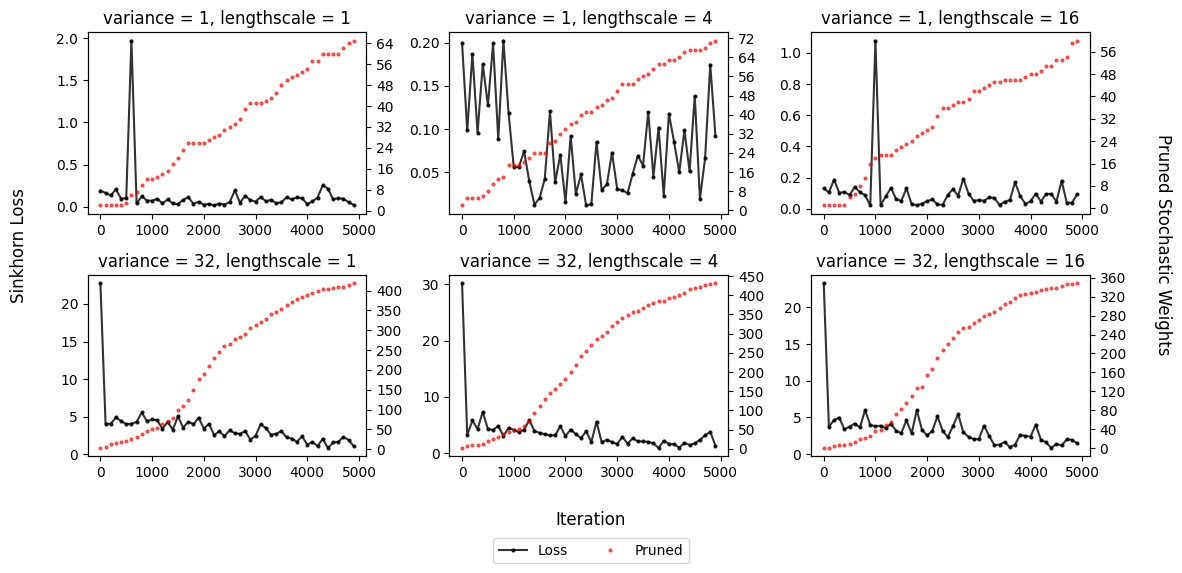

In [14]:
indices = np.arange(num_iters_sd)[::100]
fig, axs = plt.subplots(2, 3, figsize=(11, 5), sharex=False, dpi=100)

# For collecting legend handles/labels
all_handles = []
all_labels = []

for i, variance in enumerate(variances):
    for j, lengthscale in enumerate(lengthscales):
        sdist_file = os.path.join(OUT_DIR, f"len_{lengthscale}_var_{variance}", "loss_values.log")
        sdist_vals = np.loadtxt(sdist_file)
        pruned_file = os.path.join(OUT_DIR, f"len_{lengthscale}_var_{variance}", "pruned_values.log")
        pruned_vals = np.loadtxt(pruned_file)

        # Plot loss on primary axis
        h1, = axs[i, j].plot(indices, sdist_vals[indices], "-ok", ms=2, alpha=0.8, label="Loss")
        axs[i, j].set_title(rf"variance = {variance}, lengthscale = {lengthscale}")

        # Plot pruned weights on secondary y-axis
        ax2 = axs[i, j].twinx()
        h2, = ax2.plot(indices, pruned_vals[indices], "ro", ms=2, alpha=0.6, label="Pruned")
        ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

        if i == 0 and j == 0:  # Only collect once (or use a set to avoid duplicates)
            all_handles.extend([h1, h2])
            all_labels.extend(["Loss", "Pruned"])

# Shared axis labels
fig.text(0.5, -0.05, "Iteration", ha="center", va="center", fontsize=12)
fig.text(-0.02, 0.5, "Sinkhorn Loss", ha="center", va="center", rotation=90, fontsize=12)
fig.text(1.02, 0.5, "Pruned Stochastic Weights", ha="center", va="center", rotation=270, fontsize=12)

# Add legend outside the figure (bottom center)
fig.legend(all_handles, all_labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.15))

plt.tight_layout()
plt.show()

# 4. Sample from posterior using SGHMC sampler

In [ ]:
index = 0
for variance in variances:
    for lengthscale in lengthscales:
        print("----" * 20)
        print("Lengthscale: {}; Variance: {}".format(lengthscale, variance))
        
        data_loader = data_utils.DataLoader(
                    data_utils.TensorDataset(torch.from_numpy(X), torch.from_numpy(y)),
                    batch_size=sampler_batch_size, shuffle=True)
        weights_mask , bias_mask = masks_list[index]
        index+=1
        # Setup the likelihood
        net = MLPMasked(input_dim, output_dim, hidden_dims, activation_fn, weight_masks=weights_mask, bias_masks= bias_mask,
                task="classification")
        likelihood = LikCategorical()
        
        # Load the optimized prior
        saved_dir = os.path.join(OUT_DIR, "len_{}_var_{}".format(
            lengthscale, variance))
        ckpt_path = os.path.join(saved_dir, "ckpts", "sparse-it-{}.ckpt".format(num_iters_sd))
        print("Loading prior: {}".format(ckpt_path))
        prior = OptimGaussianPrior(ckpt_path)
        
        # Initialize the Bayesian net
        samples_dir = os.path.join(saved_dir, "samples")
        util.ensure_dir(samples_dir)
        bayes_net = ClassificationNetMasked(net, likelihood, prior, saved_dir, n_gpu=0)
        
        # Start sampling using SGHMC sampler
        bayes_net.sample_multi_chains(data_loader=data_loader, **sampling_configs)
        mean_preds, preds = bayes_net.evaluate(data_loader, True, True)

        # Make predictions using the posterior
        preds = []
        pred_means = []
        targets = []
        with torch.no_grad():
            for i, (data, target) in enumerate(data_loader):
                pred_mean, pred = bayes_net.predict(
                    data, return_individual_predictions=True,
                    num_samples=40)

                pred_means.append(pred_mean)
                preds.append(pred)
                targets.append(target)

        pred_means = torch.cat(pred_means, dim=0).cpu().numpy()
        preds = torch.cat(preds, dim=1).cpu().numpy()
        targets = torch.cat(targets, dim=0).cpu().numpy()
        x_grid = np.linspace(-3, 3, 40)
        xx, yy = np.meshgrid(x_grid, x_grid)
        Xplot = np.vstack((xx.flatten(), yy.flatten())).T

        p, _ = bayes_net.predict(torch.from_numpy(Xplot).float(), True, True)
        p = p.cpu().numpy()
        
        # Save the predictions to file
        data = { "xx": xx, "yy": yy, "X": X, "y": y, "p": p}
        with open(os.path.join(saved_dir, "preds.pickle"), 'wb') as f:
            pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
        
        print("----" * 20)

--------------------------------------------------------------------------------
Lengthscale: 1; Variance: 1
Loading prior: ./exp/banana/len_1_var_1/ckpts/sparse-it-5000.ckpt
Chain: 1
Samples #     5 : NLL = 0.13632 Acc = 1.0000 
Samples #    10 : NLL = 0.12213 Acc = 0.9375 
Samples #    15 : NLL = 0.18213 Acc = 0.9062 
Samples #    20 : NLL = 0.26264 Acc = 0.8750 
Samples #    25 : NLL = 0.15627 Acc = 0.9688 
Samples #    30 : NLL = 0.10839 Acc = 1.0000 
Chain: 2
Samples #    35 : NLL = 0.11594 Acc = 0.9688 
Samples #    40 : NLL = 0.09872 Acc = 1.0000 
Samples #    45 : NLL = 0.13859 Acc = 0.9375 
Samples #    50 : NLL = 0.16301 Acc = 0.9375 
Samples #    55 : NLL = 0.06710 Acc = 1.0000 
Samples #    60 : NLL = 0.21118 Acc = 0.8750 
Chain: 3
Samples #    65 : NLL = 0.17027 Acc = 0.9375 
Samples #    70 : NLL = 0.04716 Acc = 1.0000 
Samples #    75 : NLL = 0.12338 Acc = 0.9375 
Samples #    80 : NLL = 0.21740 Acc = 0.9375 
Samples #    85 : NLL = 0.07711 Acc = 1.0000 
Samples #    90 

120it [00:00, 342.24it/s]


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Lengthscale: 4; Variance: 1
Loading prior: ./exp/banana/len_4_var_1/ckpts/sparse-it-5000.ckpt
Chain: 1
Samples #     5 : NLL = 0.05331 Acc = 1.0000 
Samples #    10 : NLL = 0.16916 Acc = 0.9688 
Samples #    15 : NLL = 0.17761 Acc = 0.9062 
Samples #    20 : NLL = 0.20445 Acc = 0.9375 
Samples #    25 : NLL = 0.15049 Acc = 0.9062 
Samples #    30 : NLL = 0.07128 Acc = 1.0000 
Chain: 2
Samples #    35 : NLL = 0.25021 Acc = 0.8438 
Samples #    40 : NLL = 0.17338 Acc = 0.9688 
Samples #    45 : NLL = 0.06593 Acc = 1.0000 
Samples #    50 : NLL = 0.07566 Acc = 1.0000 
Samples #    55 : NLL = 0.06337 Acc = 1.0000 
Samples #    60 : NLL = 0.06341 Acc = 1.0000 
Chain: 3
Samples #    65 : NLL = 0.08729 Acc = 0.9375 
Samples #    70 : NLL = 0.10694 Acc = 0.9688 
Samples #    75 : NLL = 0.19300 Acc = 0.9375 
Samples #    80 : NLL = 0.2

120it [00:00, 318.28it/s]


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Lengthscale: 16; Variance: 1
Loading prior: ./exp/banana/len_16_var_1/ckpts/sparse-it-5000.ckpt
Chain: 1
Samples #     5 : NLL = 0.17357 Acc = 0.9375 
Samples #    10 : NLL = 0.05954 Acc = 0.9688 
Samples #    15 : NLL = 0.14372 Acc = 0.9688 
Samples #    20 : NLL = 0.01892 Acc = 1.0000 
Samples #    25 : NLL = 0.14208 Acc = 0.9062 
Samples #    30 : NLL = 0.11184 Acc = 0.9688 
Chain: 2
Samples #    35 : NLL = 0.15750 Acc = 0.9375 
Samples #    40 : NLL = 0.09212 Acc = 1.0000 
Samples #    45 : NLL = 0.23688 Acc = 0.8438 
Samples #    50 : NLL = 0.19687 Acc = 0.9375 
Samples #    55 : NLL = 0.10680 Acc = 0.9688 
Samples #    60 : NLL = 0.14362 Acc = 0.9688 
Chain: 3
Samples #    65 : NLL = 0.21889 Acc = 0.9375 
Samples #    70 : NLL = 0.21718 Acc = 0.9375 
Samples #    75 : NLL = 0.23086 Acc = 0.9375 
Samples #    80 : NLL = 0

120it [00:00, 337.40it/s]


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Lengthscale: 1; Variance: 32
Loading prior: ./exp/banana/len_1_var_32/ckpts/sparse-it-5000.ckpt
Chain: 1
Samples #     5 : NLL = 0.21879 Acc = 0.9062 
Samples #    10 : NLL = 0.09175 Acc = 0.9688 
Samples #    15 : NLL = 0.24608 Acc = 0.9375 
Samples #    20 : NLL = 0.15480 Acc = 0.9375 
Samples #    25 : NLL = 0.21183 Acc = 0.9375 
Samples #    30 : NLL = 0.17503 Acc = 0.9375 
Chain: 2
Samples #    35 : NLL = 0.20715 Acc = 0.8438 
Samples #    40 : NLL = 0.07086 Acc = 0.9688 
Samples #    45 : NLL = 0.06743 Acc = 1.0000 
Samples #    50 : NLL = 0.17052 Acc = 0.9375 
Samples #    55 : NLL = 0.10461 Acc = 1.0000 
Samples #    60 : NLL = 0.07207 Acc = 1.0000 
Chain: 3
Samples #    65 : NLL = 0.15302 Acc = 0.9375 
Samples #    70 : NLL = 0.05076 Acc = 1.0000 
Samples #    75 : NLL = 0.09228 Acc = 1.0000 
Samples #    80 : NLL = 0

120it [00:00, 349.01it/s]


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Lengthscale: 4; Variance: 32
Loading prior: ./exp/banana/len_4_var_32/ckpts/sparse-it-5000.ckpt
Chain: 1
Samples #     5 : NLL = 0.17685 Acc = 0.9375 
Samples #    10 : NLL = 0.13031 Acc = 0.9688 
Samples #    15 : NLL = 0.14381 Acc = 0.9688 
Samples #    20 : NLL = 0.17940 Acc = 1.0000 
Samples #    25 : NLL = 0.19213 Acc = 0.9062 
Samples #    30 : NLL = 0.21130 Acc = 0.8750 
Chain: 2
Samples #    35 : NLL = 0.13078 Acc = 0.9375 
Samples #    40 : NLL = 0.22401 Acc = 0.9062 
Samples #    45 : NLL = 0.20603 Acc = 0.9062 
Samples #    50 : NLL = 0.08431 Acc = 1.0000 
Samples #    55 : NLL = 0.13891 Acc = 0.9688 
Samples #    60 : NLL = 0.08577 Acc = 1.0000 
Chain: 3
Samples #    65 : NLL = 0.22124 Acc = 0.9062 
Samples #    70 : NLL = 0.10770 Acc = 0.9688 
Samples #    75 : NLL = 0.12453 Acc = 0.9688 
Samples #    80 : NLL = 0

120it [00:00, 350.57it/s]


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Lengthscale: 16; Variance: 32
Loading prior: ./exp/banana/len_16_var_32/ckpts/sparse-it-5000.ckpt
Chain: 1
Samples #     5 : NLL = 0.14465 Acc = 0.9688 
Samples #    10 : NLL = 0.14688 Acc = 0.9688 
Samples #    15 : NLL = 0.14709 Acc = 0.9688 
Samples #    20 : NLL = 0.21352 Acc = 0.8750 
Samples #    25 : NLL = 0.23658 Acc = 0.9375 
Samples #    30 : NLL = 0.10779 Acc = 0.9688 
Chain: 2
Samples #    35 : NLL = 0.20895 Acc = 0.9375 
Samples #    40 : NLL = 0.08875 Acc = 1.0000 
Samples #    45 : NLL = 0.17196 Acc = 0.9688 
Samples #    50 : NLL = 0.07643 Acc = 1.0000 
Samples #    55 : NLL = 0.19320 Acc = 0.9375 
Samples #    60 : NLL = 0.13297 Acc = 0.9688 
Chain: 3
Samples #    65 : NLL = 0.22076 Acc = 0.9375 
Samples #    70 : NLL = 0.13062 Acc = 0.9688 
Samples #    75 : NLL = 0.09315 Acc = 0.9688 
Samples #    80 : NLL =

120it [00:00, 351.45it/s]


--------------------------------------------------------------------------------


# 5. Visualize predictive posterior

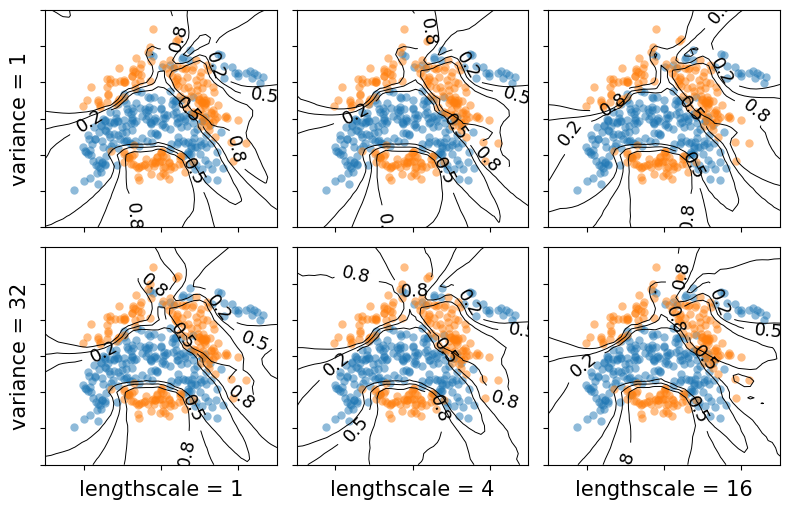

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=3, tight_layout=False,
                        figsize=(8, 5.2), sharex=True, sharey=True, dpi=100)

for i, variance in enumerate(variances):
    for j, lengthscale in enumerate(lengthscales):
        data_file = os.path.join(OUT_DIR, "len_{}_var_{}".format(lengthscale, variance),
                                  "preds.pickle")
        
        with open(data_file, "rb") as f:
            data = pickle.load(f)
        
        X = data['X']
        y = data['y']
        p = data['p']
        xx = data['xx']
        yy = data['yy']

        mask = y.reshape([-1, 1])[:, 0] == 1
        Xplot = np.vstack((xx.flatten(), yy.flatten())).T
        
        ax[i, j].plot(X[mask, 0], X[mask, 1], "oC0", mew=0, alpha=0.5, ms=6)
        ax[i, j].plot(X[np.logical_not(mask), 0], X[np.logical_not(mask), 1], "oC1", mew=0, alpha=0.5, ms=6)
        CS = ax[i, j].contour(
            xx,
            yy,
            p[:, 0].reshape(*xx.shape),
            [0.2, 0.5, 0.8],
            colors="k",
            linewidths=0.7,
            zorder=100,
        )
        ax[i, j].clabel(CS, inline=1, fontsize=13, fmt='%1.1f')
        ax[i, j].set_xticklabels([])
        ax[i, j].set_yticklabels([])
        
        if j == 0:
            ax[i, j].set_ylabel(r"variance = {}".format(variance), fontsize=15)
        if i == 1:
            ax[i, j].set_xlabel(r"lengthscale = {}".format(lengthscale), fontsize=15)
            
plt.tight_layout()
plt.show()